In [2]:
%matplotlib inline

In [4]:
import numpy as np
from os import listdir
import re
import pandas as pd
# -----------------------------------------------------------------------------
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
plt.style.use('../data_plot/lato_style.mplstyle')

# Load Data

In [5]:
mu0 = 4 * np.pi * 1e-7
Ms = 0.658e6


data = pd.read_csv('../sim/InitialMagnetisation_w50_ordered.omf', comment='#',
                   header=None, delim_whitespace=True)

data_mx0 = data.as_matrix()[:, 3] / Ms
data_my0 = data.as_matrix()[:, 4] / Ms
data_mz0 = data.as_matrix()[:, 5] / Ms

coordinates = data.as_matrix()[:, :3] * 1e9

nx = len(np.unique(coordinates[:, 0]))
ny = len(np.unique(coordinates[:, 1]))

ucoords_x = np.unique(coordinates[:, 0])
ucoords_y = np.unique(coordinates[:, 1])

centre_x = coordinates[:, 0].min() + (coordinates[:, 0].max()
                                      - coordinates[:, 0].min()
                                      ) * 0.5

# Periodic DMI and excitation region

In [6]:
def exc_region(x):
    xrel = x - centre_x
    
    if (xrel <= 2) and (xrel >= -2):
        return True
    else:
        return False
    
exc_region = np.vectorize(exc_region)

In [7]:
def periodic_dmi_x(p1, p2, x):
    xr = x % (p1 + p2)
    
    if xr < p1:
        return 2
    elif xr >= p1 and xr <= (p1 + p2):
        return 1
    else:
        return 0

# Make this function to work element-wise
periodic_dmi_x = np.vectorize(periodic_dmi_x)

In [8]:
regions = periodic_dmi_x(50, 50, coordinates[:, 0])

# Set the excitation region with value 3
exc_field = exc_region(coordinates[:, 0])
regions[exc_field] = 3

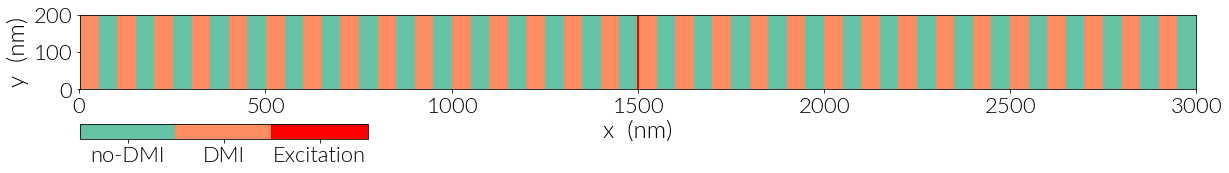

In [13]:
# Define a custom colormap
cmap = plt.cm.Set2
# Extract colors from the map
cmaplist = [cmap(0), cmap(1), (1., 0., 0.)]
# create the new map
cmap = matplotlib.colors.ListedColormap(cmaplist, 'Custom cmap', 3)

fig = plt.figure(figsize=(20, 2))
plt.imshow(regions.reshape(-1, nx), cmap=cmap,
           extent=[ucoords_x.min(), ucoords_x.max(), ucoords_y.min(), ucoords_y.max()]
           )
plt.yticks([0, 100, 200])
plt.ylabel('y  (nm)')
plt.xlabel('x  (nm)')

# create a second axes for the colorbar
ax2 = fig.add_axes([0.125, -0.1, 0.2, 0.1])
cb = matplotlib.colorbar.ColorbarBase(ax2, cmap=cmap, spacing='proportional', 
                                      ticks=[1.5, 2.5, 3.5], orientation='horizontal',
                                      boundaries=np.linspace(1, 4, 4))
cb.set_ticklabels(['no-DMI', 'DMI', 'Excitation'])

# plt.savefig('simulation_system_a100nm_w50nm.pdf', bbox_inches='tight')
plt.savefig('../images/simulation_system_a100nm_w50nm.png', bbox_inches='tight')

# Exponential damping

In [10]:
def exp_damping(alpha, xmin, xmax, width, x):
    xa = xmin + width
    xb = xmax - width
    
    if x <= xa:
        return np.exp((xmin - x) * np.log(alpha) / (xmin - xa))
    elif x >= xb:
        return np.exp((xmax - x) * np.log(alpha) / (xmax - xb))
    else:
        return alpha
    
exp_damping = np.vectorize(exp_damping)

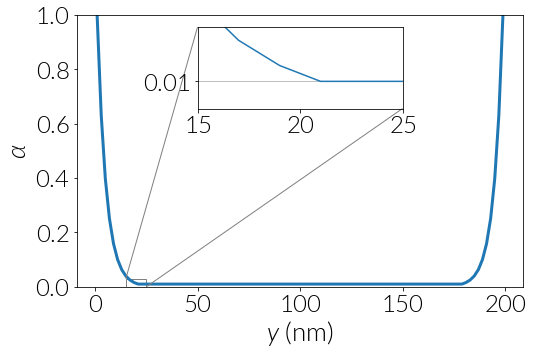

In [12]:
damping_y = exp_damping(0.01, 1, 199, 20, ucoords_y)

plt.figure(figsize=(8, 8/1.6))
plt.plot(ucoords_y, damping_y, lw=3)
plt.ylim([0, 1])

plt.ylabel(r'$\alpha$')
plt.xlabel(r'$y\,\,\mathrm{(nm)}$')
ax = plt.gca()

axins = zoomed_inset_axes(ax, 10, loc=9) # zoom-factor: 5, location: 
axins.plot(ucoords_y, damping_y)
x1, x2, y1, y2 = 15, 25, 0, 0.03 # specify the limits
axins.set_xlim(x1, x2) # apply the x-limits
axins.set_ylim(y1, y2) # apply the y-limits
plt.yticks([0.01])
plt.grid(axis='y')
mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec="0.5")

# plt.savefig('exponential_damping_along_width.pdf', bbox_inches='tight')
plt.savefig('exponential_damping_along_width.png', bbox_inches='tight')